In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from matplotlib import gridspec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import (KMeans, AgglomerativeClustering, 
                             DBSCAN, OPTICS, cluster_optics_dbscan)
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import (silhouette_score, calinski_harabasz_score, 
                                     silhouette_samples, contingency_matrix)

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

In [40]:
def drawSillouette(X, labels, header="", ax=None):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)
    
    if ax==None:
        fig, ax = plt.subplots(1,1, figsize=(10,8))
        
    ax.set_xlim([-0.5, 1])
    ax.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax.set_title("Silhouette plot "+ header)
    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Clusters")
    ax.axvline(x=sil_avg, c="r", linestyle="--")

    ax.set_yticks([]) 


In [4]:
def plot_distance_density(data, dist_func, include_peaks=True):
    dists_avg = dist_func(data).mean(axis=1)
    v,c = np.unique(dists_avg, return_counts=True)
    
    kde = gaussian_kde(v, weights=c)
    density = kde(v)
    
    plt.plot(v, density)
    plt.xlabel("Average Distance")
    plt.ylabel("Density")
    
    if include_peaks:
        peaks, _ = find_peaks(density)
        plt.plot(v[peaks], density[peaks], "r*", label="Peak")
        plt.legend()

In [5]:
def get_n_cluster_based_scores(model, clusters, X, score_func):
    scores = []
    
    for c in tqdm(clusters):
        model.n_clusters = c
        model.fit(X)
        
        scores.append( score_func(X, model.labels_) )
        
    return scores

In [29]:
def get_dbs_scores(optics, eps, X, score_func):
    scores = []
    
    for i in tqdm(eps):
        dbs_labels = cluster_optics_dbscan(
            reachability=optics.reachability_,
            core_distances=optics.core_distances_,
            ordering=optics.ordering_,
            eps = i
        )
    
        nunique=len(np.unique(X))
        if nunique==1:
            break

        scores.append( score_func(X, dbs_labels) )
    return scores

In [6]:
def plot_scores(x,y, xlabel="", ylabel="", title="", ax=None):
    if ax==None:
        f, ax = plt.subplots(1,1)
    ax.plot(x,y, "--*")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [22]:
def plot_reachability(space, reachibility, X, labels, threshold=None):

    if threshold==None:
        reach_filter = reachibility<np.inf
    else:
        reach_filter = reachibility<threshold
    
    filtered_labels = labels[reach_filter]
    filtered_space = space[reach_filter]
    filtered_reach = reachability[reach_filter]
    
    
    plt.figure(figsize=(10,5))
    colors = ["r", "b", "y", "g", "orange", "c", "m", "purple", "olive", "aqua", "tomato"]
    plt.plot(filtered_space[filtered_labels==-1], filtered_reach[filtered_labels==-1], "k.", alpha=0.2,)

    for k, color in zip(np.unique(labels), colors):
        if k!=-1:
            Xk = filtered_space[filtered_labels==k]
            Rk = filtered_reach[filtered_labels==k]
            plt.plot(Xk, Rk, ".", c=color, alpha=0.2)

    plt.ylabel("Reachability (epsilon distance)")
    plt.title("Reachability Plot")
    plt.grid()

In [159]:
def print_models_statistics(X, model_labels, model_names):
    for labels, name in zip(model_labels, model_names):
        print(name, 
              f"| Silhouette = {silhouette_score(X, labels):.3f} \
              | Calinski = {calinski_harabasz_score(X, labels):.3f} \
              | Number of clusters = {len(np.unique(labels))}"
             )

## Train dataset

In [ ]:
df_dense = pd.read_csv("train.csv").drop(columns="critical_temp")

In [ ]:
df_sparse.columns[df_sparse.std()==0]

In [ ]:
plot_distance_density(df_dense, euclidean_distances)

### Hierarchical Clustering

In [ ]:
clusters = np.arange(2, 8+1)

- Single Linkage

In [ ]:
sil = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="single"), clusters, df_dense, silhouette_score)
cal = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="single"), clusters, df_dense, calinski_harabasz_score)

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(clusters, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Single Linkage", ax=ax[0])
plot_scores(clusters, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Single Linkage", ax=ax[1])

- Complete Linkage

In [ ]:
sil = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="complete"), clusters, df_dense, silhouette_score)
cal = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="complete"), clusters, df_dense, calinski_harabasz_score)

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(clusters, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Complete Linkage", ax=ax[0])
plot_scores(clusters, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Complete Linkage", ax=ax[1])

- Average Linkage

In [ ]:
sil = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="average"), clusters, df_dense, silhouette_score)
cal = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="average"), clusters, df_dense, calinski_harabasz_score)

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(clusters, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Average Linkage", ax=ax[0])
plot_scores(clusters, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Average Linkage", ax=ax[1])

- Ward Linkage

In [ ]:
sil = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="ward"), clusters, df_dense, silhouette_score)
cal = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="ward"), clusters, df_dense, calinski_harabasz_score)

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(clusters, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Ward Linkage", ax=ax[0])
plot_scores(clusters, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Ward Linkage", ax=ax[1])

### KMeans

In [ ]:
ks = np.arange(2, 8+1)
sil = get_n_cluster_based_scores(KMeans(n_init="auto", random_state=13), ks, df_dense, silhouette_score)
cal = get_n_cluster_based_scores(KMeans(n_init="auto", random_state=13), ks, df_dense, calinski_harabasz_score)

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(ks, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Kmeans", ax=ax[0])
plot_scores(ks, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Kmeans", ax=ax[1])

### DBSCAN

In [ ]:
opts_sparse = OPTICS(min_cluster_size=0.05, min_samples=0.02, n_jobs=-1).fit(df_dense)

space = np.arange(len(df_sparse))
reachability = opts_sparse.reachability_[opts_sparse.ordering_]
labels = opts_sparse.labels_[opts_sparse.ordering_]

In [ ]:
space = np.arange(len(df_dense))
reachability = opts.reachability_[opts.ordering_]
labels = opts.labels_[opts.ordering_]
unique_labels = np.unique(labels)

In [ ]:
len(unique_labels)

In [ ]:
plt.figure(figsize=(10,5))
colors = ["r", "b", "y", "g", "orange", "c", "m", "purple", "olive", "aqua", "tomato"]
for k, color in zip(unique_labels, colors):
    Xk = space[labels==k]
    Rk = reachability[labels==k]
    plt.plot(Xk, Rk, ".", c=color, alpha=0.3)

plt.plot(space[labels==-1], reachability[labels==-1], "k.", alpha=0.3,)
#plt.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3) #<--- the UNASSIGNED POINTS
plt.ylabel("Reachability (epsilon distance)")
plt.title("Reachability Plot")
plt.grid()
plt.show()

In [ ]:
dbs_labels = cluster_optics_dbscan(
    reachability=opts.reachability_,
    core_distances=opts.core_distances_,
    ordering=opts.ordering_,
    eps=2.5
)
unique_labels= np.unique(dbs_labels)

In [ ]:
len(unique_labels)

In [ ]:
plt.plot(space[dbs_labels==-1], reachability[dbs_labels==-1], "k.", alpha=0.3,)
for k, color in zip(unique_labels, colors):
    if k!=-1:
        Xk = space[dbs_labels==k]
        Rk = reachability[dbs_labels==k]
        plt.plot(Xk, Rk, ".", c=color, alpha=0.3)
#plt.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3) #<--- the UNASSIGNED POINTS
plt.ylabel("Reachability (epsilon distance)")
plt.title("Reachability Plot")
plt.grid()
plt.show()

In [ ]:
dbs_sil_scores = []
dbs_cal_scores = []
eps = np.linspace(0.5, 10, 10)
for i in tqdm(eps):
    dbs_labels = cluster_optics_dbscan(
        reachability=opts.reachability_,
        core_distances=opts.core_distances_,
        ordering=opts.ordering_,
        eps=i
    )
    
    dbs_sil_scores.append( silhouette_score(df_dense, dbs_labels) )
    dbs_cal_scores.append( calinski_harabasz_score(df_dense, dbs_labels) )

In [ ]:
f, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(eps, dbs_sil_scores, "--o")
ax[0].set_xlabel("Eps")
ax[0].set_ylabel("Silhouette Score")

    
ax[1].plot(eps, dbs_cal_scores, "--o")
ax[1].set_xlabel("Eps")
ax[1].set_ylabel("Calinski Score")

In [ ]:
eps

In [ ]:
dbs_labels = cluster_optics_dbscan(
    reachability=opts.reachability_,
    core_distances=opts.core_distances_,
    ordering=opts.ordering_,
    eps=4
)
unique_labels= np.unique(dbs_labels)

In [ ]:
len(unique_labels)

In [ ]:
plt.plot(space[dbs_labels==-1], reachability[dbs_labels==-1], "k.", alpha=0.3,)
for k, color in zip(unique_labels, colors):
    if k!=-1:
        Xk = space[dbs_labels==k]
        Rk = reachability[dbs_labels==k]
        plt.plot(Xk, Rk, ".", c=color, alpha=0.3)
#plt.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3) #<--- the UNASSIGNED POINTS
plt.ylabel("Reachability (epsilon distance)")
plt.title("Reachability Plot")
plt.grid()
plt.show()

In [ ]:
drawSillouette(df_dense, dbs_labels)

## Unique Dataset

In [8]:
df_sparse = pd.read_csv("unique_m.csv").drop(columns=["material", "critical_temp"])

In [9]:
constant_cols = df_sparse.columns[df_sparse.std()==0]

In [10]:
df_sparse = df_sparse.drop(columns=constant_cols)

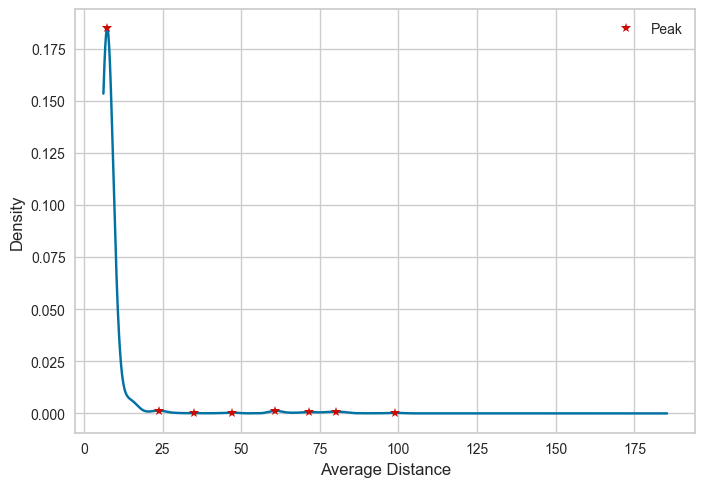

In [11]:
plot_distance_density(df_sparse, euclidean_distances)

### Hierarchical Clustering

In [ ]:
clusters = np.arange(2, 8+1)

- Single Linkage

In [132]:
sil = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="single"), clusters, df_sparse, silhouette_score)
cal = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="single"), clusters, df_sparse, calinski_harabasz_score)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

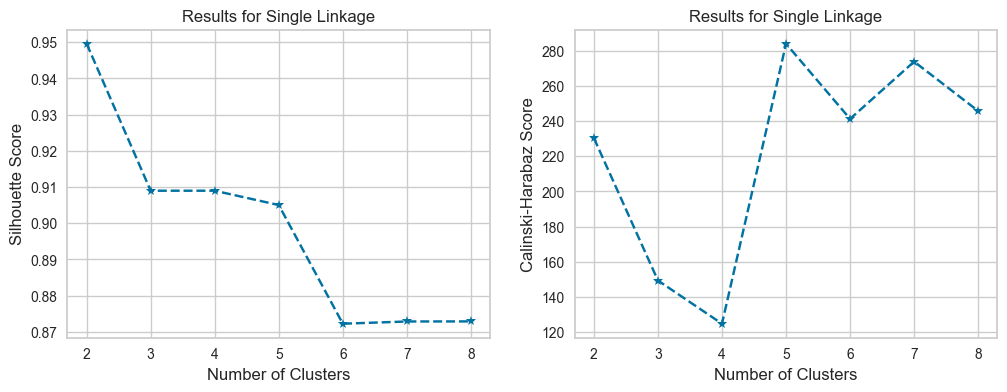

In [133]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(clusters, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Single Linkage", ax=ax[0])
plot_scores(clusters, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Single Linkage", ax=ax[1])

- Complete Linkage

In [134]:
sil = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="complete"), clusters, df_sparse, silhouette_score)
cal = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="complete"), clusters, df_sparse, calinski_harabasz_score)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

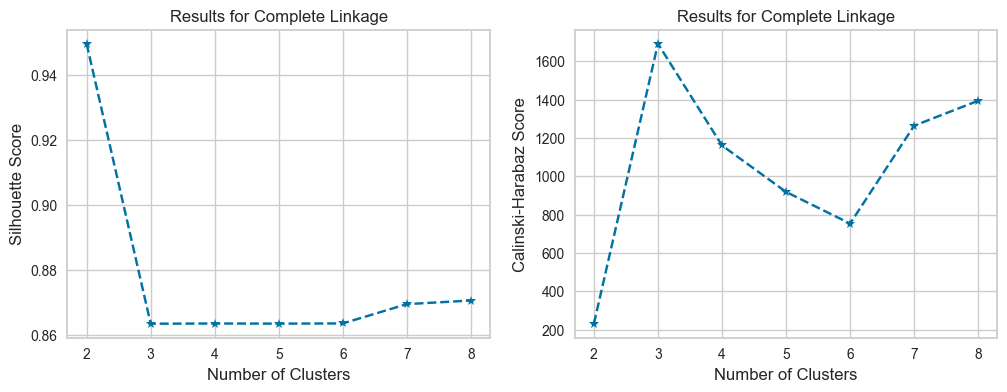

In [135]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(clusters, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Complete Linkage", ax=ax[0])
plot_scores(clusters, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Complete Linkage", ax=ax[1])

- Average Linkage

In [136]:
sil = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="average"), clusters, df_sparse, silhouette_score)
cal = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="average"), clusters, df_sparse, calinski_harabasz_score)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

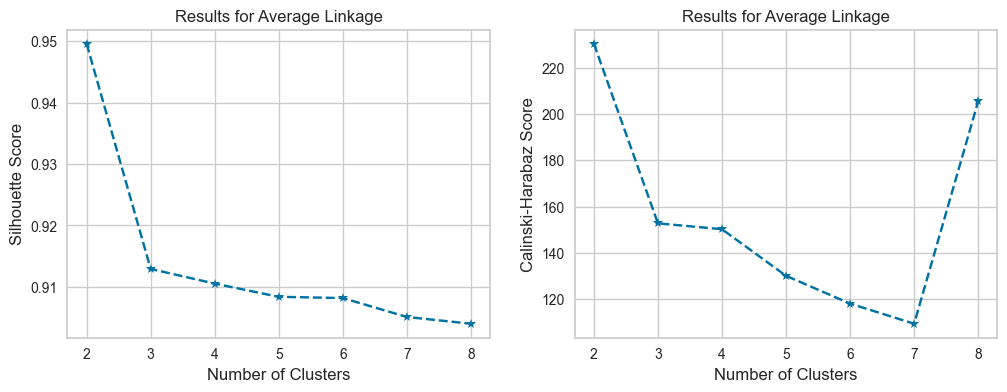

In [137]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(clusters, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Average Linkage", ax=ax[0])
plot_scores(clusters, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Average Linkage", ax=ax[1])

- Ward Linkage

In [95]:
sil = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="ward"), clusters, df_sparse, silhouette_score)
cal = get_n_cluster_based_scores(AgglomerativeClustering(metric="euclidean", linkage="ward"), clusters, df_sparse, calinski_harabasz_score)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

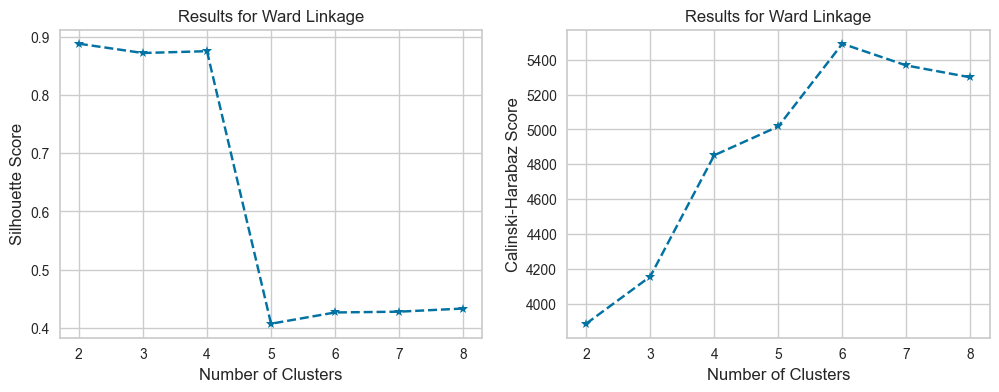

In [96]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(clusters, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Ward Linkage", ax=ax[0])
plot_scores(clusters, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Ward Linkage", ax=ax[1])

### Kmeans

In [97]:
ks = np.arange(2, 8+1)
sil = get_n_cluster_based_scores(KMeans(n_init="auto", random_state=13), ks, df_sparse, silhouette_score)
cal = get_n_cluster_based_scores(KMeans(n_init="auto", random_state=13), ks, df_sparse, calinski_harabasz_score)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

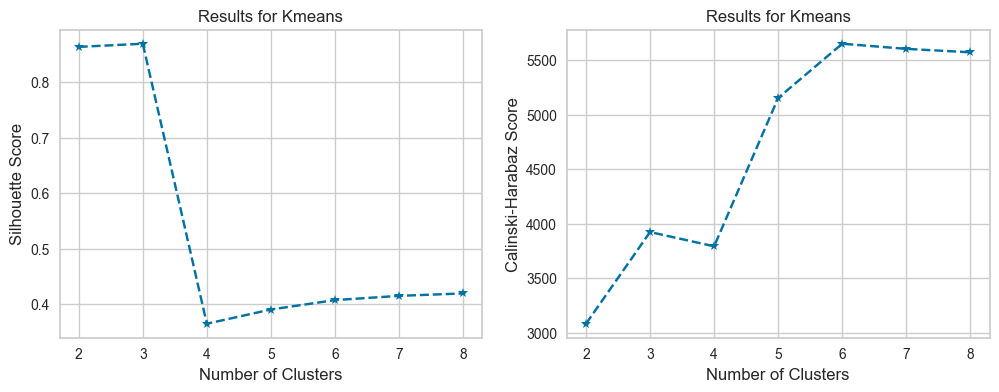

In [98]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(ks, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for Kmeans", ax=ax[0])
plot_scores(ks, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for Kmeans", ax=ax[1])

### DBSCAN

In [102]:
opts_sparse = OPTICS(min_cluster_size=0.05, min_samples=0.02, n_jobs=-1).fit(df_sparse)

space = np.arange(len(df_sparse))
reachability = opts_sparse.reachability_[opts_sparse.ordering_]
labels = opts_sparse.labels_[opts_sparse.ordering_]

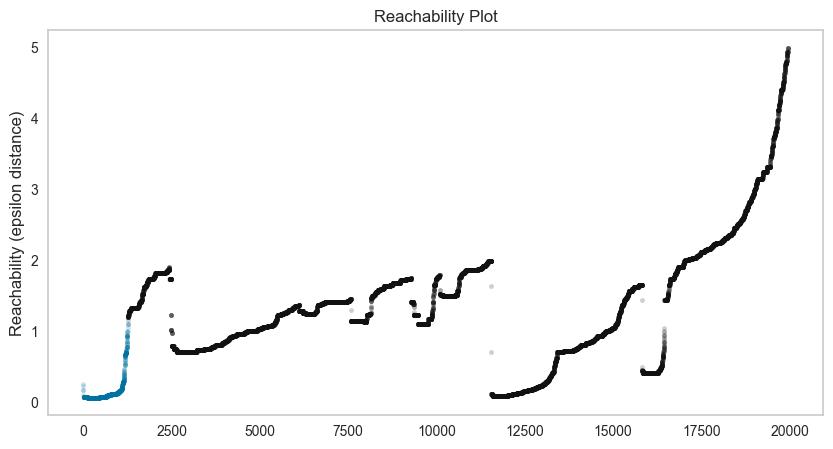

In [104]:
plot_reachability( space, reachability, df_sparse, labels, 5)

In [105]:
eps = np.arange(0.5, 2.25, 0.25)
sil = get_dbs_scores(opts_sparse, eps, df_sparse, silhouette_score)
cal = get_dbs_scores(opts_sparse, eps, df_sparse, calinski_harabasz_score)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

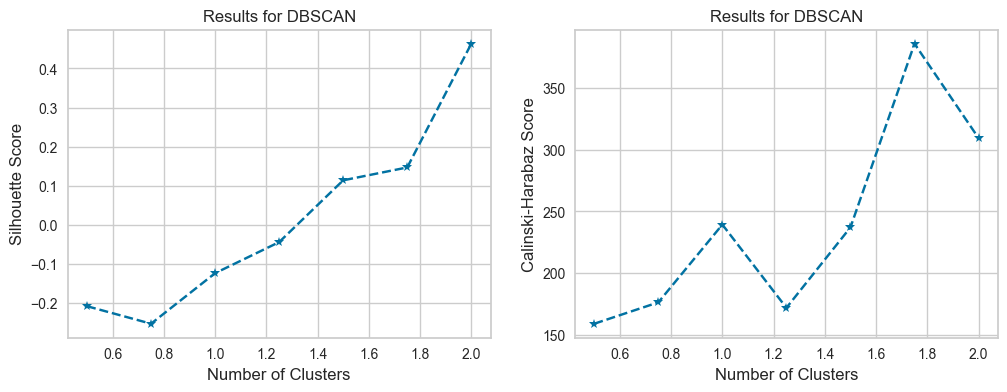

In [106]:
f, ax = plt.subplots(1,2, figsize=(12,4))
plot_scores(eps, sil, xlabel="Number of Clusters", ylabel="Silhouette Score", title="Results for DBSCAN", ax=ax[0])
plot_scores(eps, cal, xlabel="Number of Clusters", ylabel="Calinski-Harabaz Score", title="Results for DBSCAN", ax=ax[1])

In [107]:
dbs_labels = cluster_optics_dbscan(
    reachability=opts_sparse.reachability_,
    core_distances=opts_sparse.core_distances_,
    ordering=opts_sparse.ordering_,
    eps=1.75
)

In [108]:
silhouette_score(df_sparse[dbs_labels!=-1], dbs_labels[dbs_labels!=-1])

0.43494444055511294

In [109]:
calinski_harabasz_score(df_sparse[dbs_labels!=-1], dbs_labels[dbs_labels!=-1])

17210.49999244793

### Compare Best Ones

In [138]:
hac = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="complete").fit(df_sparse)
kmeans = KMeans(n_clusters=3, n_init="auto", random_state=13).fit(df_sparse)
dbs_labels = cluster_optics_dbscan(reachability=opts_sparse.reachability_, core_distances=opts_sparse.core_distances_, ordering=opts_sparse.ordering_, eps=1.75)

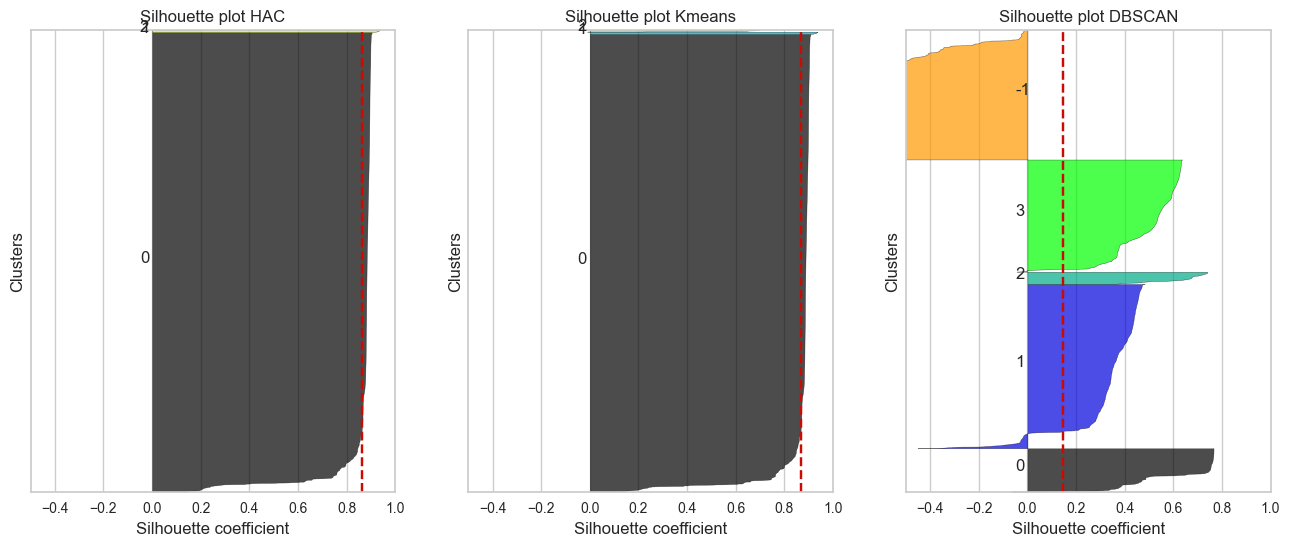

In [139]:
f, ax = plt.subplots(1,3,figsize=(16,6))

drawSillouette(df_sparse, hac.labels_, "HAC", ax=ax[0])
drawSillouette(df_sparse, kmeans.labels_, "Kmeans", ax=ax[1])
drawSillouette(df_sparse, dbs_labels, "DBSCAN", ax=ax[2])

In [160]:
print_models_statistics(df_sparse, [hac.labels_, kmeans.labels_, dbs_labels], ["hac", "kmeans", "dbscan"])

hac | Silhouette = 0.863               | Calinski = 1691.373               | Number of clusters = 3
kmeans | Silhouette = 0.869               | Calinski = 3921.939               | Number of clusters = 3
dbscan | Silhouette = 0.146               | Calinski = 385.565               | Number of clusters = 5


In [157]:
silhouette_score(df_sparse[dbs_labels!=-1], dbs_labels[dbs_labels!=-1])

0.43494444055511294

In [158]:
calinski_harabasz_score(df_sparse[dbs_labels!=-1], dbs_labels[dbs_labels!=-1])

17210.49999244793

As expected from the density plot, it seems there is one major cluster. This type of clusters is dificult to be captured by the dbscan algorithm if there is low density. Howeever, the dbscan algorithm could capture some very dense clusters too. This might be dense clusters within a sparse cluster or maybe random clusters within the major cluster